In [1]:
# IMPORT
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path

# bokeh
import bokeh.palettes
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Legend, ColumnDataSource, Title
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.models import GeoJSONDataSource

output_notebook()

Loading BokehJS ...

# Data Preprocessing

**Clean and export `air_quality_data.csv`**

**Clean and export `air_quality_stations.csv`**

# Visualisations

Load and join tables

In [2]:
# load air quality stations
df_stations = pd.read_csv('shared_data/air_quality/air_quality_stations.csv')
# load magnitud table
df_magnitud = pd.read_csv('shared_data/air_quality/air_quality_magnitud.csv', sep=';')
# load air quality data
df = pd.read_csv('data/air_quality_data.csv')
# converting Date to datetime type
df["datetime"] = pd.to_datetime(df["datetime"])
# merge with air quality stations
df = pd.merge(df, df_stations, left_on = 'PUNTO_MUESTREO', right_on='punto_muestreo', how='left').drop('PUNTO_MUESTREO', axis=1)
# merge with air quality magnitud
df = pd.merge(df, df_magnitud, left_on = 'MAGNITUD', right_on='magnitud_id', how='left').drop('MAGNITUD', axis=1)
df.head()

PROVINCIA  MUNICIPIO  ESTACION  value            datetime  punto_muestreo  \
0         28         79         4    7.0 2016-04-01 01:00:00        28079004   
1         28         79         4    8.0 2016-04-02 01:00:00        28079004   
2         28         79         4   10.0 2016-04-03 01:00:00        28079004   
3         28         79         4    7.0 2016-04-04 01:00:00        28079004   
4         28         79         4    8.0 2016-04-05 01:00:00        28079004   

              name  longitude   latitude  altitude          utm_x  \
0  Plaza de España  -3.712197  40.423883       637 -413239.904502   
1  Plaza de España  -3.712197  40.423883       637 -413239.904502   
2  Plaza de España  -3.712197  40.423883       637 -413239.904502   
3  Plaza de España  -3.712197  40.423883       637 -413239.904502   
4  Plaza de España  -3.712197  40.423883       637 -413239.904502   

          utm_y  magnitud_id formula unit_per_m3  
0  4.927732e+06            1     SO2          µg  
1  4.927732e+06            1     SO2          µg  
2  4.927732e+06            1     SO2          µg  
3  4.927732e+06            1     SO2          µg  
4  4.927732e+06            1     SO2          µg

Get the names of air quality stations:

In [3]:
print('AIR QUALITY STATION NAMES:')
df.name.unique()

AIR QUALITY STATION NAMES:


array(['Plaza de España', 'Escuelas Aguirre', 'Ramón y Cajal',
       'Arturo Soria', 'Villaverde', 'Farolillo', 'Casa de Campo',
       'Barajas Pueblo', 'Plaza del Carmen', 'Moratalaz',
       'Cuatro Caminos', 'Barrio del Pilar', 'Vallecas', 'Méndez Álvaro',
       'Castellana', 'Retiro', 'Plaza Castilla', 'Ensanche de Vallecas',
       'Urbanización Embajada', 'Plaza Elíptica', 'Sanchinarro',
       'El Pardo', 'Juan Carlos I', 'Tres Olivos'], dtype=object)

Choose a location (station `name`) and a gas to track (`MAGNITUD` id):

In [6]:
aLocation = 'Plaza de España'
aFormula = 'NO2'

df_focus = df[(df.name == aLocation) & (df.formula==aFormula)]
df_focus.sort_values('datetime')

,PROVINCIA,MUNICIPIO,ESTACION,value,datetime,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,magnitud_id,formula,unit_per_m3
1944765,28,79,4,57.0,2016-01-01 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
1949446,28,79,4,55.0,2016-01-01 02:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
1954127,28,79,4,57.0,2016-01-01 03:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
1958808,28,79,4,54.0,2016-01-01 04:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
1963489,28,79,4,51.0,2016-01-01 05:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103229,28,79,4,0.0,2021-10-25 20:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
7107291,28,79,4,0.0,2021-10-25 21:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
7111353,28,79,4,0.0,2021-10-25 22:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
7115415,28,79,4,0.0,2021-10-25 23:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg


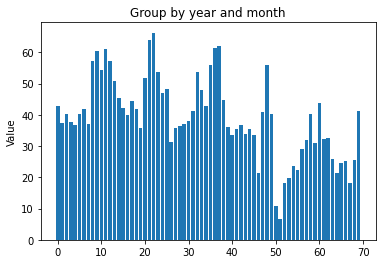

In [7]:
# plot bars
heights = df_focus.groupby([df_focus.datetime.dt.year, df_focus.datetime.dt.month]).mean().value.values
plt.bar(range(len(heights)), heights)
plt.title('Group by year and month')
plt.ylabel('Value')
plt.show()

### Air Quality Stations (map)

In [6]:
# load MC area
cm_points = pd.read_csv('shared_data/districts/central_madrid_points.csv')

# red = outside MC, blue = inside MC

points = df_stations[["utm_x", "utm_y"]].values
path = Path(cm_points[["utm_x", "utm_y"]].values)
points_in_path_mask = path.contains_points(points)

df_stations["color"] = "red"

df_stations.loc[points_in_path_mask, "color"] = "blue"
df_stations.head()

,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,color
0,28079035,Plaza del Carmen,-3.703167,40.419208,660,-412234.627656,4.927049e+06,blue
1,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,red
2,28079039,Barrio del Pilar,-3.711536,40.478233,676,-413166.309950,4.935683e+06,red
3,28079008,Escuelas Aguirre,-3.682283,40.421564,672,-409909.905623,4.927393e+06,red
4,28079038,Cuatro Caminos,-3.707122,40.445547,699,-412674.958086,4.930901e+06,red


In [38]:
# plot map
p = figure(title="Air quality stations in Madrid", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(df_stations)
cr = p.circle(x="utm_x", y="utm_y",  size=10, color="color", source=source)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

p.add_tools(HoverTool(tooltips=[('Name', '@name')], renderers=[cr]))

show(p)

---

In [8]:
import json
import utm
import numpy as np
import seaborn as sns

np.random.seed(42)

In [9]:
with open("shared_data/districts/districts.geojson", "r") as geojson:
    geodata = json.load(geojson)

In [11]:
def utm_from_latlon(lat, lon):
    """ From a given lat and lon, calculates the correct UTM coordinates to 
        plot using `bokeh` 
    """
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale

    return x, y

def get_lat_lon_utm(row):
    """ From a row containing the columns 'st_x' and 'st_y' calculates both the lat and lon
        and the correct UTM coordinates to plot using `bokeh`
    """

    # 30 and 'T' is the zone of Madrid
    lat, lon = utm.to_latlon(row["st_x"], row["st_y"], 30, "T")
    
    x, y = utm_from_latlon(lat, lon)

    return pd.Series([lat, lon, x, y])

In [11]:
df_districts = pd.DataFrame([], columns=["name", "latitude",
                                         "longitude", "utm_x",
                                         "utm_y"])
for district in geodata["features"]:
    # Get district name
    district_name = district["properties"]["NOMBRE"]
    
    # Get district coordinates
    district_coord = district["geometry"]["coordinates"][0]
    df_district = pd.DataFrame(district["geometry"]["coordinates"][0], columns=["st_x", "st_y"])
    df_district["name"] = district_name
    
    # Calculate correct utm
    df_district[["latitude", "longitude", "utm_x", "utm_y"]] = df_district.apply(get_lat_lon_utm, axis=1)
    df_district = df_district.drop(columns=["st_x", "st_y"])
    
    # Append to all districts dataframe
    df_districts = pd.concat([df_districts, df_district]).reset_index(drop=True)


district_name = df_districts["name"].unique()
df_districts

,name,latitude,longitude,utm_x,utm_y
0,Centro,40.407345,-3.693162,-411120.867401,4925314.358763
1,Centro,40.407196,-3.693202,-411125.341089,4925292.526182
2,Centro,40.406986,-3.693227,-411128.197118,4925261.789915
3,Centro,40.407127,-3.693677,-411178.251532,4925282.481746
4,Centro,40.407256,-3.693849,-411197.420454,4925301.309521
...,...,...,...,...,...
9466,Moncloa - Aravaca,40.469899,-3.802628,-423306.659924,4934463.574953
9467,Moncloa - Aravaca,40.469823,-3.802359,-423276.645066,4934452.379956
9468,Moncloa - Aravaca,40.469748,-3.802093,-423247.03994,4934441.47116
9469,Moncloa - Aravaca,40.469672,-3.801822,-423216.881019,4934430.303684


In [12]:
stations_points = df_stations.copy()
stations_points.head()

,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,color
0,28079035,Plaza del Carmen,-3.703167,40.419208,660,-412234.627656,4.927049e+06,blue
1,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,red
2,28079039,Barrio del Pilar,-3.711536,40.478233,676,-413166.309950,4.935683e+06,red
3,28079008,Escuelas Aguirre,-3.682283,40.421564,672,-409909.905623,4.927393e+06,red
4,28079038,Cuatro Caminos,-3.707122,40.445547,699,-412674.958086,4.930901e+06,red


In [13]:
stations_points["district"] = "None"
points = stations_points[["utm_x", "utm_y"]]

for name in district_name:
    path = Path(df_districts[df_districts["name"] == name][["utm_x", "utm_y"]])
    points_in_path_mask = path.contains_points(points)
    stations_points.loc[points_in_path_mask, "district"] = name
    
stations_points = stations_points.drop(stations_points[stations_points["district"] == "None"].index)\
                .reset_index(drop=True)

stations_points.head()

,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,color,district
0,28079035,Plaza del Carmen,-3.703167,40.419208,660,-412234.627656,4.927049e+06,blue,Centro
1,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,red,Moncloa - Aravaca
2,28079039,Barrio del Pilar,-3.711536,40.478233,676,-413166.309950,4.935683e+06,red,Fuencarral - El Pardo
3,28079008,Escuelas Aguirre,-3.682283,40.421564,672,-409909.905623,4.927393e+06,red,Salamanca
4,28079038,Cuatro Caminos,-3.707122,40.445547,699,-412674.958086,4.930901e+06,red,Chamberí


In [14]:
district_colors = sns.color_palette('Spectral', len(district_name))
np.random.shuffle(district_colors)
district_colors

[(0.7126489811610919, 0.10711264898116109, 0.28081507112648985),
 (0.3600153787004998, 0.7161860822760476, 0.6655132641291811),
 (0.5910034602076126, 0.835524798154556, 0.6442906574394464),
 (0.8141484044598232, 0.2196847366397539, 0.3048058439061899),
 (0.9963860053825452, 0.8879661668589004, 0.5610918877354863),
 (0.9817762399077278, 0.6073817762399076, 0.3457900807381776),
 (0.9557862360630527, 0.9823144944252211, 0.6800461361014996),
 (0.9330257593233372, 0.3913110342176086, 0.27197231833910035),
 (0.26405228758169935, 0.6091503267973857, 0.7098039215686275),
 (0.47427912341407163, 0.7898500576701268, 0.6459823144944252),
 (0.8202998846597465, 0.9275663206459055, 0.6126874279123413),
 (0.8758169934640523, 0.3045751633986928, 0.29411764705882354),
 (0.9982314494425221, 0.9451749327181853, 0.6570549788542868),
 (0.2941945405613224, 0.4062283737024224, 0.680968858131488),
 (0.9665513264129182, 0.49742406766628217, 0.295040369088812),
 (0.9096501345636295, 0.9638600538254518, 0.6080738177623992),
 (0.9946943483275663, 0.8092272202998846, 0.48696655132641287),
 (0.998077662437524, 0.9992310649750096, 0.7460207612456747),
 (0.7114186851211075, 0.8832756632064592, 0.6348327566320646),
 (0.21299500192233756, 0.5114186851211072, 0.730795847750865),
 (0.9928489042675894, 0.716955017301038, 0.40945790080738165)]

In [15]:
def get_color_from_palette(color):
    """ Getting colors for plotting """
    return tuple([int(c * 255) for c in color])

def get_dark_color_from_palette(color):
    """ Getting darker colors for plotting """
    return tuple([int(c * 200) for c in color])

In [31]:
p = figure(title="Air quality stations in Madrid", x_axis_type="mercator", y_axis_type="mercator",
           height=700, width=800)

for name, color in zip(district_name, district_colors):
    # Districts
    source = ColumnDataSource(df_districts[df_districts["name"] == name])
    p.patch(x="utm_x", y="utm_y", color=get_color_from_palette(color), line_width=3, alpha=0.4, 
            source=source, legend_label=name, muted=True, muted_alpha=0.1)
    # Air quality stations points
    source = ColumnDataSource(stations_points[stations_points["district"] == name])
    p.circle(x="utm_x", y="utm_y", color=get_color_from_palette(color), line_width=1,
            source=source, legend_label=name, muted=True, muted_alpha=0.3, radius=400,
            line_color=get_dark_color_from_palette(color))
    
# Madrid Central
source = ColumnDataSource(df_districts[df_districts["name"] == "Centro"])
p.line(x="utm_x", y="utm_y", color="black", line_width=2, 
        source=source, legend_label="Madrid Central limit", muted=False, muted_alpha=0.3)

# Hover tooltip
p.add_tools(HoverTool(tooltips=[('Name', '@name'), ('ID','@punto_muestreo')]))


cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)
p.add_layout(p.legend[0], "right")
p.legend.click_policy = "mute"
show(p)

---

### Compare two districts

In [17]:
# select districts and gas to track
aLocation = 'Plaza de España'
aLocation2 = 'Plaza del Carmen'
aMagnitud = 8 #NO2

# filtering
df_focus2 = df[(df.name.isin([aLocation, aLocation2])) & (df.MAGNITUD==aMagnitud)]
# get values comparison per year
df_focus2.groupby([df_focus2.name, df_focus2.datetime.dt.year]).describe()['value']

count       mean        std   min   25%   50%  \
name             datetime                                                   
Plaza de España  2016      8783.0  45.645907  28.450476   0.0  25.0  40.0   
                 2017      8760.0  49.411301  30.644147   0.0  27.0  43.0   
                 2018      8760.0  42.955023  26.700519   0.0  23.0  38.0   
                 2019      8736.0  39.528159  27.182600   0.0  20.0  33.0   
                 2020      7104.0  30.214527  27.181571   0.0  11.0  24.0   
                 2021      6769.0  28.163392  27.843819   0.0  11.0  21.0   
Plaza del Carmen 2016      8471.0  45.721520  23.205295   0.0  28.0  42.0   
                 2017      8760.0  49.088470  23.108229   0.0  31.0  45.0   
                 2018      8616.0  44.132892  21.332328   0.0  28.0  41.0   
                 2019      8712.0  35.901515  23.361379   0.0  18.0  30.0   
                 2020      8784.0  29.520947  22.097664   0.0  13.0  22.0   
                 2021      8760.0  31.356963  22.012821   0.0  15.0  25.0   
                 2022         1.0  55.000000        NaN  55.0  55.0  55.0   

                             75%     max  
name             datetime                 
Plaza de España  2016      61.00   250.0  
                 2017      66.00   283.0  
                 2018      57.00   226.0  
                 2019      53.00   210.0  
                 2020      43.25  1117.0  
                 2021      38.00  1162.0  
Plaza del Carmen 2016      59.00   194.0  
                 2017      63.00   188.0  
                 2018      57.00   261.0  
                 2019      49.00   185.0  
                 2020      41.00   148.0  
                 2021      43.00   209.0  
                 2022      55.00    55.0

---

## Plot aditional information for NO2

In [38]:
df_no2 = df[df["MAGNITUD"]== 8].reset_index(drop=True)
df_no2["day"] = df_no2["datetime"].dt.day
df_no2["month"] = df_no2["datetime"].dt.month
df_no2["year"] = df_no2["datetime"].dt.year
df_no2["day_of_week"] = df_no2["datetime"].dt.day_name()

df_no2 = df_no2[df_no2["year"].isin(range(2016, 2022))].reset_index(drop=True)
df_no2

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,value,datetime,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,day,month,year,day_of_week
0,28,79,4,8,10.0,2016-04-01 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,4,2016,Friday
1,28,79,4,8,35.0,2016-04-02 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,2,4,2016,Saturday
2,28,79,4,8,67.0,2016-04-03 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,3,4,2016,Sunday
3,28,79,4,8,20.0,2016-04-04 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,4,4,2016,Monday
4,28,79,4,8,48.0,2016-04-05 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,5,4,2016,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255484,28,79,60,8,37.0,2021-09-27 00:00:00,28079060,Tres Olivos,-3.689731,40.500547,715,-410738.926609,4.938949e+06,27,9,2021,Monday
1255485,28,79,60,8,74.0,2021-09-28 00:00:00,28079060,Tres Olivos,-3.689731,40.500547,715,-410738.926609,4.938949e+06,28,9,2021,Tuesday
1255486,28,79,60,8,23.0,2021-09-29 00:00:00,28079060,Tres Olivos,-3.689731,40.500547,715,-410738.926609,4.938949e+06,29,9,2021,Wednesday
1255487,28,79,60,8,21.0,2021-09-30 00:00:00,28079060,Tres Olivos,-3.689731,40.500547,715,-410738.926609,4.938949e+06,30,9,2021,Thursday


In [39]:
df_no2 = df_no2.groupby(["name", "year", "month", "day", "day_of_week"]).agg(mean_value=("value", "mean")).reset_index()

df_no2

,name,year,month,day,day_of_week,mean_value
0,Arturo Soria,2016,1,1,Friday,41.043478
1,Arturo Soria,2016,1,2,Saturday,28.250000
2,Arturo Soria,2016,1,3,Sunday,41.833333
3,Arturo Soria,2016,1,4,Monday,23.291667
4,Arturo Soria,2016,1,5,Tuesday,32.458333
...,...,...,...,...,...,...
52350,Villaverde,2021,12,27,Monday,17.208333
52351,Villaverde,2021,12,28,Tuesday,24.625000
52352,Villaverde,2021,12,29,Wednesday,47.458333
52353,Villaverde,2021,12,30,Thursday,62.875000


In [40]:
df_no2_centro = df_no2[df_no2["name"] == "Plaza del Carmen"].reset_index(drop=True)
df_no2_centro

,name,year,month,day,day_of_week,mean_value
0,Plaza del Carmen,2016,1,1,Friday,39.652174
1,Plaza del Carmen,2016,1,2,Saturday,32.041667
2,Plaza del Carmen,2016,1,3,Sunday,35.666667
3,Plaza del Carmen,2016,1,4,Monday,22.791667
4,Plaza del Carmen,2016,1,5,Tuesday,35.833333
...,...,...,...,...,...,...
2170,Plaza del Carmen,2021,12,27,Monday,13.250000
2171,Plaza del Carmen,2021,12,28,Tuesday,18.666667
2172,Plaza del Carmen,2021,12,29,Wednesday,41.208333
2173,Plaza del Carmen,2021,12,30,Thursday,54.041667


Year Analysis

In [42]:
df_centro_year = df_no2_centro.groupby("year").agg(mean_value_year = ("mean_value", "mean")).reset_index()

df_year = df_no2.groupby("year").agg(mean_value_year = ("mean_value", "mean")).reset_index()

display(df_centro_year)
df_year

,year,mean_value_year
0,2016,45.595569
1,2017,49.088470
2,2018,43.892233
3,2019,35.804413
4,2020,29.520947
5,2021,31.356963


,year,mean_value_year
0,2016,38.481594
1,2017,41.523451
2,2018,36.514495
3,2019,34.464994
4,2020,27.199124
5,2021,28.900958


In [48]:
p = figure(title="Average NO2 value per day through the years in Madrid Central and in the city of Madrid", x_axis_label="Year",
           y_axis_label="NO2 value average by day", width=800)

source = ColumnDataSource(df_centro_year)
p.vbar(x="year", top="mean_value_year", source=source, width=0.5, legend_label="Madrid Central", color=get_color_from_palette(district_colors[5]))

source = ColumnDataSource(df_year)
p.line(x="year", y="mean_value_year", source=source, line_width=3, legend_label="Madrid", color=get_color_from_palette(district_colors[8]))

# Hover tooltip
TOOLTIPS = [
    ("Average Intensity per day", "@mean_value_year"),
    ("Year", "@year")
    ]
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

p.add_layout(p.legend[0], "right")


show(p)

Month Analysis

In [49]:
months_name = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

df_centro_month = df_no2_centro.groupby("month").agg(mean_value_month = ("mean_value","mean")).reset_index()
df_month = df_no2.groupby("month").agg(mean_value_month = ("mean_value", "mean")).reset_index()

df_centro_month["month_name"] = df_centro_month.apply(lambda x: months_name[int(x["month"]-1)], axis=1)
df_month["month_name"] = df_month.apply(lambda x: months_name[int(x["month"]-1)], axis=1)


display(df_centro_month)                                                                         
df_month

,month,mean_value_month,month_name
0,1,51.313318,January
1,2,47.445588,February
2,3,37.375304,March
3,4,31.092361,April
4,5,29.580421,May
5,6,30.229861,June
6,7,33.970654,July
7,8,32.868837,August
8,9,39.149537,September
9,10,47.690860,October


,month,mean_value_month,month_name
0,1,48.198367,January
1,2,42.494529,February
2,3,32.368025,March
3,4,26.156869,April
4,5,24.156561,May
5,6,24.834983,June
6,7,26.518928,July
7,8,25.629712,August
8,9,34.680941,September
9,10,41.837746,October


In [50]:
p = figure(title="Average NO2 value per day in a month in Madrid Central and in the city of Madrid", x_axis_label="Month",
           y_axis_label="NO2 value average by day", width=1000, x_range=months_name)

source = ColumnDataSource(df_centro_month)
p.vbar(x="month_name", top="mean_value_month", source=source, width=0.5, legend_label="Madrid Central", color=get_color_from_palette(district_colors[5]))

source = ColumnDataSource(df_month)
p.line(x="month_name", y="mean_value_month", source=source, line_width=3, legend_label="Madrid", color=get_color_from_palette(district_colors[8]))

# Hover tooltip
TOOLTIPS = [
    ("Average Intensity per day", "@mean_value_month"),
    ("Month", "@month_name")
    ]
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

p.add_layout(p.legend[0], "right")


show(p)

Weekly Analysis

In [51]:
week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_centro_week = df_no2_centro.groupby("day_of_week").agg(mean_value_week = ("mean_value", "mean")).reset_index()
df_week = df_no2.groupby("day_of_week").agg(mean_value_week = ("mean_value", "mean")).reset_index()

df_centro_week["day_of_week"] = df_centro_week["day_of_week"].astype("category")
df_centro_week["day_of_week"] = df_centro_week["day_of_week"].cat.set_categories(week_days)

df_centro_week = df_centro_week.sort_values("day_of_week")


df_week["day_of_week"] = df_week["day_of_week"].astype("category")
df_week["day_of_week"] = df_week["day_of_week"].cat.set_categories(week_days)

df_week = df_week.sort_values("day_of_week")

display(df_centro_week)
df_week

,day_of_week,mean_value_week
1,Monday,38.880178
5,Tuesday,42.060155
6,Wednesday,42.131565
4,Thursday,42.239014
0,Friday,41.294590
2,Saturday,35.544220
3,Sunday,31.916802


,day_of_week,mean_value_week
1,Monday,34.384376
5,Tuesday,37.382081
6,Wednesday,37.778542
4,Thursday,38.334969
0,Friday,36.963279
2,Saturday,30.346053
3,Sunday,26.477958


In [52]:
p = figure(title="Average NO2 value per day in a week in Madrid Central and in the city of Madrid", x_axis_label="Weekday",
           y_axis_label="NO2 value average by day", width=1000, x_range=week_days)

source = ColumnDataSource(df_centro_week)
p.vbar(x="day_of_week", top="mean_value_week", source=source, width=0.5, legend_label="Madrid Central", color=get_color_from_palette(district_colors[5]))

source = ColumnDataSource(df_week)
p.line(x="day_of_week", y="mean_value_week", source=source, line_width=3, legend_label="Madrid", color=get_color_from_palette(district_colors[8]))

# Hover tooltip
TOOLTIPS = [
    ("Average Intensity per day", "@mean_value_week"),
    ("Day of the Week", "@day_of_week")
    ]
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

p.add_layout(p.legend[0], "right")


show(p)

Test dataset sizes

In [59]:
process_df = df[df["MAGNITUD"].isin([6, 8])].reset_index(drop=True)

process_df["day"] = process_df["datetime"].dt.day
process_df["month"] = process_df["datetime"].dt.month
process_df["year"] = process_df["datetime"].dt.year
process_df["day_of_week"] = process_df["datetime"].dt.day_name()

process_df = process_df[process_df["year"].isin(range(2016, 2022))].reset_index(drop=True)

process_df = process_df.groupby(["name", "year", "month", "day", "day_of_week"]).agg(mean_value=("value", "mean")).reset_index()



process_df
# select districts and gas to track
aLocation = 'Plaza de España'
aLocation2 = 'Plaza del Carmen'
aFormula = 'NO2'

# filtering
df_focus2 = df[(df.name.isin([aLocation, aLocation2])) & (df.formula==aFormula)]
# get values comparison per year
df_focus2.groupby([df_focus2.name, df_focus2.datetime.dt.year]).describe()['value']

,name,year,month,day,day_of_week,mean_value
0,Arturo Soria,2016,1,1,Friday,20.697826
1,Arturo Soria,2016,1,2,Saturday,14.277083
2,Arturo Soria,2016,1,3,Sunday,21.100000
3,Arturo Soria,2016,1,4,Monday,11.766667
4,Arturo Soria,2016,1,5,Tuesday,16.387500
...,...,...,...,...,...,...
52352,Villaverde,2021,12,27,Monday,17.208333
52353,Villaverde,2021,12,28,Tuesday,24.625000
52354,Villaverde,2021,12,29,Wednesday,47.458333
52355,Villaverde,2021,12,30,Thursday,62.875000


## Visualisation 1: evolution of TRAP in Centro over time

*Compute the average and std of the value for each recorded gas.*

In [180]:
df1 = df[(df.name == 'Plaza del Carmen')][['formula','value','datetime']]
df1 = df1.pivot(index='datetime', columns='formula', values='value').reset_index()
df1['datetime'] = df1.datetime.dt.round('D')
df1['datetime'] = df1['datetime'] + pd.offsets.MonthBegin(0)

In [181]:
# get mean
df1_mean = df1.groupby(['datetime']).mean().reset_index()
df1_mean["datetime"] = pd.to_datetime(df1_mean["datetime"])
df1_mean = df1_mean.set_index('datetime')

In [182]:
def get_month_year(aRow):
    return aRow.name.month_name() + ' ' + str(aRow.name.year)

df1_mean['date'] = df1_mean.apply(get_month_year, axis=1)

In [183]:
df1_mean

formula,CO,NO,NO2,NOx,O3,SO2,date
datetime,,,,,,,
2016-01-01,0.409091,20.181818,49.000000,79.909091,12.931818,5.181818,January 2016
2016-02-01,0.413826,33.343624,46.096644,97.063087,23.471195,8.277852,February 2016
2016-03-01,0.373094,24.923741,42.732374,80.733813,23.210259,10.964029,March 2016
2016-04-01,0.347919,15.177181,45.410738,68.629530,32.291570,10.608054,April 2016
2016-05-01,0.294028,11.781944,41.305556,59.368056,40.624861,12.383333,May 2016
...,...,...,...,...,...,...,...
2021-09-01,0.228129,3.226110,22.519515,27.488560,74.582880,7.010767,September 2021
2021-10-01,0.276667,7.250000,29.358333,39.593056,52.918181,8.258333,October 2021
2021-11-01,0.326309,11.645638,39.773154,57.628188,50.358980,2.710067,November 2021


*Convert your `DataFrame` to Bokeh `ColumnDataSource`.*

In [184]:
cds_mean = ColumnDataSource(data=df1_mean)

In [185]:
df1_mean.columns

Index(['CO', 'NO', 'NO2', 'NOx', 'O3', 'SO2', 'date'], dtype='object', name='formula')

*Generate Bokeh figure*

In [186]:
p = figure(
    width=950, 
    height=400, 
    x_axis_type="datetime",
    title='Evolution of polluting gases over time in Centro, Madrid', 
    y_axis_label='gas concentration', 
    x_axis_label='date'
)

# create color palette
colors_gas = dict(zip(df1_mean.columns.values,list(bokeh.palettes.brewer['Dark2'][len(df1_mean.columns.values)])))

# add the data of each gas
lines, circles = {}, {}
for aGas in df1_mean.columns.values:
    # add line
    lines[aGas] = p.line('datetime', aGas, source=cds_mean, color = colors_gas[aGas])
    # add dots
    circles[aGas] = p.circle('datetime',aGas, source=cds_mean, color=colors_gas[aGas], size=5, alpha=0.3)
    p.add_tools(HoverTool(tooltips=[(aGas, '@'+aGas), ('date', '@date')], renderers=[circles[aGas]]))

# add interactive legend
items = [] 
for i in list(lines.keys())[:-1]:
    unit = df_magnitud[df_magnitud.formula==i].unit_per_m3.values[0]
    items.append((f'{i} ({unit}/m3)', [lines[i], circles[i]]))
legend = Legend(items=items, location='center') 
legend.click_policy="hide"
p.add_layout(legend, 'right')

show(p)

### Compare with the month of the previous year

In [196]:
# get mean
df2_mean = df1.groupby(['datetime']).mean().reset_index()
df2_mean["datetime"] = pd.to_datetime(df2_mean["datetime"])
df2_mean = df2_mean.set_index('datetime')
df2_mean["month"] = df2_mean.index.month
df2_mean["year"] = df2_mean.index.year

# get percentage
def get_progress_percent(aRow):
    previousRow = df2_mean[(df2_mean.month==aRow.month) & (df2_mean.year==aRow.year-1)]
    if len(previousRow) != 0:
        previousRow = previousRow.iloc[0]
        ratios = (aRow - previousRow)/previousRow
        datetime_to_keep = aRow.name
        ratios.name = datetime_to_keep
        ratios.month = datetime_to_keep.month
        ratios.year = datetime_to_keep.year
        return ratios
    return None
df2_ratios = df2_mean[df2_mean.year > 2016].apply(get_progress_percent, axis=1)

# get date display
df2_ratios['date'] = df2_ratios.apply(get_month_year, axis=1)

# drop SO2 (outlier)
df2_ratios = df2_ratios.drop('SO2',axis=1)

# bokeh
cds_ratios = ColumnDataSource(data=df2_ratios)

p = figure(
    width=950, 
    height=400, 
    x_axis_type="datetime",
    title='Evolution of polluting gases over time in Centro, Madrid', 
    y_axis_label='gas concentration', 
    x_axis_label='date'
)

# add the data of each gas
lines, circles = {}, {}
for aGas in df2_ratios.columns.values[:-3]:
    # add line
    lines[aGas] = p.line('datetime', aGas, source=cds_ratios, color = colors_gas[aGas])
    # add dots
    circles[aGas] = p.circle('datetime',aGas, source=cds_ratios, color=colors_gas[aGas], size=5, alpha=0.3)
    p.add_tools(HoverTool(tooltips=[(aGas, '@'+aGas), ('date', '@date')], renderers=[circles[aGas]]))

p.line()

# add interactive legend
items = [] 
for i in list(lines.keys()):
    unit = df_magnitud[df_magnitud.formula==i].unit_per_m3.values[0]
    items.append((f'{i} ({unit}/m3)', [lines[i], circles[i]]))
legend = Legend(items=items, location='center') 
legend.click_policy="hide"
p.add_layout(legend, 'right')

show(p)

In [175]:
df2_ratios

formula,CO,NO,NO2,NOx,O3,SO2,month,year,date
datetime,,,,,,,,,
2017-01-01,0.377056,2.563314,0.163644,1.092865,-0.207616,0.286400,1.0,2017.0,January 2017
2017-02-01,0.255271,0.590314,0.305166,0.457186,0.558917,0.091779,2.0,2017.0,February 2017
2017-03-01,0.077302,0.063243,0.152487,0.113595,0.282072,-0.651729,3.0,2017.0,March 2017
2017-04-01,0.143502,0.633287,0.023379,0.230670,0.276458,-0.676469,4.0,2017.0,April 2017
2017-05-01,0.038734,0.058470,0.016947,0.029290,0.378867,-0.787685,5.0,2017.0,May 2017
...,...,...,...,...,...,...,...,...,...
2021-09-01,-0.149368,-0.502597,-0.052091,-0.179265,0.077867,-0.081263,9.0,2021.0,September 2021
2021-10-01,-0.155574,-0.098446,-0.013994,-0.045535,-0.141967,-0.004354,10.0,2021.0,October 2021
2021-11-01,-0.165988,0.028737,0.254253,0.176894,0.191698,-0.243300,11.0,2021.0,November 2021


In [209]:
# vertical bars
p = figure(width=900, height=300, x_axis_type="datetime")

bar ={} # to store vbars 
# here we will do a for loop to create a bar for each race
for indx,i in list(enumerate(df2_ratios))[:-3]:
    bar[i] = p.vbar(x='datetime',  top=i, source=cds_ratios, legend_label=i, alpha=0.6, color='red')
p.legend.visible = False
        
items = [] # for the custom legend // you need to figure out where to add it
for i in list(bar.keys()):
    items.append((i, [bar[i]]))
legend = Legend(items=items, location='center') # figure out where to add it
legend.click_policy="hide"

p.add_layout(legend, 'right')

show(p)

## Visualisation 2: evolution of a given gas with different